In [1]:
import sys  
sys.path.append("../../")
from LIB.utils import * 

In [2]:

v="final"

train_df=pd.read_csv("../features/final_data/train_{}.csv".format(v))
test_df=pd.read_csv("../features/final_data/test_{}.csv".format(v))

In [3]:
keys= ["ride_id"]
Target_name="number_of_ticket"
not_used_cols=["ride_id","travel_time" ,"travel_date","date","month","week",Target_name,"ratio_number_of_ticket",
                                'Speed_max_capicty',
                                 'count_travel_from',
                                 'is_tommorw_holidays',
                                 'is_yesterday_holidays'
       
]
feautres_name=[ f for f in test_df.columns if f not in not_used_cols]
from sklearn.metrics import mean_absolute_error
def eval_metrics(y_ture,y_hat):
    return mean_absolute_error(y_ture,y_hat)

In [4]:
len(feautres_name)

50

In [5]:
from LIB.xgb import * 
params= {
            'min_child_weight': 10, 
            'eta': 0.004, 
            'colsample_bytree': 0.7, 
            'max_depth': 9,
            'subsample': 0.9, 'lambda': 5, 
            'nthread': 8, 
            'booster' : 'gbtree', 
            'eval_metric': 'rmse', 
            'objective': 'reg:linear',
            "gamma":0.5 ,
            "alpha":0.04,
            'silent': 1
}
XGBoost= Xgboost_model( Train_df=train_df,
                        Test_df=test_df,
                        feval_metrics=eval_metrics,
                        Target_name=Target_name,
                        params=params,
                        feature_names=feautres_name,
                        keys=keys,
                        verbose_eval=100,
                        early_stopping_rounds=100,
                        num_boost_round=20000,
                        maximize=False,
                        test_size=0.1,
                        nbr_fold=10,
                        nbr_run=3)

Shape of Train (6249, 53)
Shape of Test (1111, 52)


In [6]:
train_pred_xgboost,test_pred_xgboost=XGBoost.Xgboost_Kfold()
# train_pred_xgboost,test_pred_xgboost=XGBoost.Xgboost_RepeatedKFold()


test_pred_xgboost[Target_name]=test_pred_xgboost[Target_name].apply(lambda x : 1 if x<0 else x ).round()

##################################################fold:1##################################################
run 0 train metrics :2.133248 val metrics : 2.9593737
run 1 train metrics :2.098275 val metrics : 2.9595273
run 2 train metrics :2.1420069 val metrics : 2.957066

fold-1 train metrics :2.12451 val metrics : 2.9586556
##################################################fold:2##################################################
run 0 train metrics :1.9194784 val metrics : 3.0993474
run 1 train metrics :1.9146036 val metrics : 3.0939279
run 2 train metrics :2.1198292 val metrics : 3.0998816

fold-2 train metrics :1.9846371 val metrics : 3.0977192
##################################################fold:3##################################################
run 0 train metrics :2.0208712 val metrics : 2.8846934
run 1 train metrics :2.13836 val metrics : 2.904566
run 2 train metrics :2.0229645 val metrics : 2.8865771

fold-3 train metrics :2.060732 val metrics : 2.8919456
######################

In [7]:

train_pred_xgboost[Target_name+"pred"]=train_pred_xgboost[Target_name+"pred"].apply(lambda x : 1 if x<0 else x ).round()
train_pred_xgboost=train_pred_xgboost.merge(train_df[["ride_id","date"]],how="left",on="ride_id")
train_pred_xgboost.date=pd.to_datetime(train_pred_xgboost.date)
Train=train_pred_xgboost[~train_pred_xgboost.date.between(datetime(2018,4,3),datetime(2018,4,20))]
Val=train_pred_xgboost[train_pred_xgboost.date.between(datetime(2018,4,3),datetime(2018,4,20))]
print( "Train")
print(mean_absolute_error(Train.number_of_ticket, Train.number_of_ticketpred))
print("Val : ")
print(mean_absolute_error(Val.number_of_ticket, Val.number_of_ticketpred))

                                            

Train
2.954966406391865
Val : 
2.998652291105121


In [8]:
test_pred_xgboost.number_of_ticket=test_pred_xgboost.number_of_ticket.round()
test_pred_xgboost.to_csv("../sub/Xboost_sub.csv",index=False)

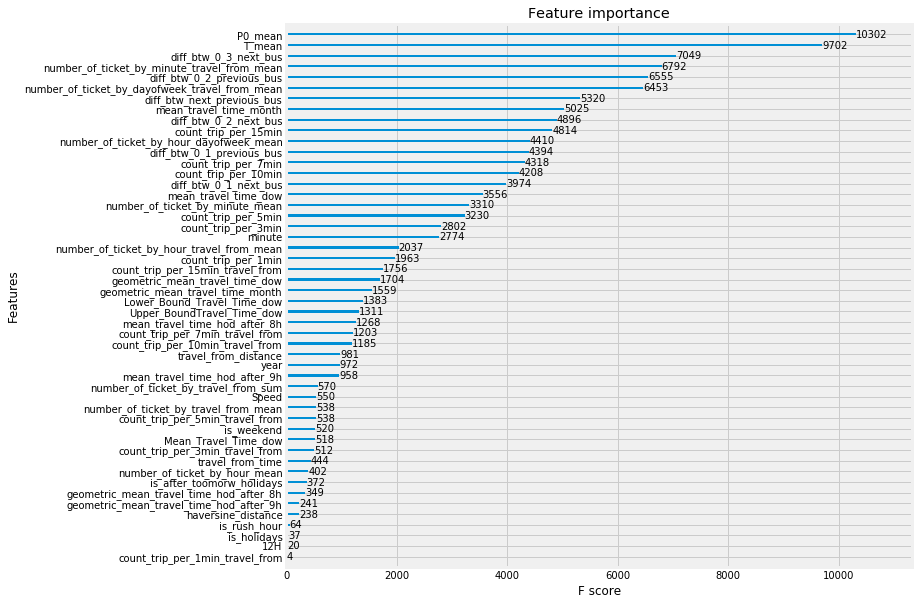

In [9]:
XGBoost.plot_importance()